In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# set the random seed - consistent
rs = 10

# load the data
#importing the data file and displaying the data types
df = pd.read_csv('D3.csv')

df[['Location', 'WindGustDir', 'WindDir9am', 
    'WindDir3pm', 'Cloud9am', 'Cloud3pm']] = df[['Location', 'WindGustDir', 'WindDir9am', 
                                                 'WindDir3pm', 'Cloud9am', 'Cloud3pm']].astype(str)

# drop Year
df.drop(['Year', 'Location', 'Month'], axis=1, inplace=True)

# one-hot encoding
df = pd.get_dummies(df)

# target/input split
y = df['RainTomorrow']
#X = df[['Humidity3pm', 'Pressure3pm', 'Rainfall', 'WindGustSpeed']]
X = df.drop(['RainTomorrow'], axis=1)

#convert X from pandas Dataframe to numpy matrix for sklearn
X_mat = X.to_numpy()

from sklearn.model_selection import train_test_split

# setting random state
rs = 10
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

In [2]:
from sklearn.preprocessing import StandardScaler

# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min -8.5, max 31.9, mean 12.21 and std dev 6.38
Variable #1: min -4.8, max 48.1, mean 23.24 and std dev 7.10
Variable #2: min 0.0, max 371.0, mean 2.37 and std dev 8.59
Variable #3: min 0.0, max 145.0, mean 5.48 and std dev 3.17
Variable #4: min 0.0, max 14.5, mean 7.61 and std dev 2.74
After scaling
-------------
Variable #0: min -3.2435110107767673, max 3.0851121630285783, mean 0.00 and std dev 1.00
Variable #1: min -3.949192863940767, max 3.501686409725393, mean 0.00 and std dev 1.00
Variable #2: min -0.27615087806300226, max 42.92717183441524, mean -0.00 and std dev 1.00
Variable #3: min -1.7283141576961072, max 43.98261239301211, mean -0.00 and std dev 1.00
Variable #4: min -2.7777448831061067, max 2.517232055162849, mean 0.00 and std dev 1.00


In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [4]:
# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.8413608831476701
Test accuracy: 0.8431772371443303
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     33101
           1       0.72      0.49      0.58      9565

    accuracy                           0.84     42666
   macro avg       0.79      0.72      0.74     42666
weighted avg       0.83      0.84      0.83     42666



In [5]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

Humidity3pm : 1.1039286061727833
Pressure3pm : -1.0305513231019459
Pressure9am : 0.6558048555551268
WindGustSpeed : 0.6522005623694803
Sunshine : -0.35324213590686276
MaxTemp : -0.29301929839809965
Cloud3pm_0 : -0.28435229034113896
Temp3pm : 0.2060414822677072
Rainfall : 0.2012485872020752
WindSpeed3pm : -0.1897548056818935
Cloud3pm_8 : 0.14887368800406572
Cloud3pm_1 : -0.1339957441218113
Humidity9am : 0.11372596608058332
MinTemp : 0.10904022985791986
Temp9am : 0.0896952054504609
Cloud3pm_7 : 0.08136018882998064
WindDir3pm_NW : 0.08067128053479372
WindDir3pm_NE : -0.07724239460483544
WindDir9am_NNE : 0.07599770339864266
Cloud9am_0 : -0.07046151721870653


In [6]:
#######################################################################################################################
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=10), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             return_train_score=True)

In [18]:
result_set = cv.cv_results_
print(result_set)

{'mean_fit_time': array([0.67620602, 0.53076673, 0.54721978, 0.89008462, 1.40327218,
       1.97533004, 1.53089054, 1.3981703 , 1.57450571, 1.45513477]), 'std_fit_time': array([0.13040089, 0.03813122, 0.05959839, 0.02985604, 0.12396857,
       0.16715092, 0.10543407, 0.08171455, 0.08055295, 0.1214965 ]), 'mean_score_time': array([0.00785093, 0.00589564, 0.00470595, 0.00724688, 0.00449848,
       0.01229067, 0.01019723, 0.00574741, 0.00460446, 0.00435488]), 'std_score_time': array([0.00800413, 0.00434099, 0.0034594 , 0.00583191, 0.00232424,
       0.01459143, 0.00968736, 0.00466378, 0.00255859, 0.0013746 ]), 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-06}, {'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C'

Total number of models:  10


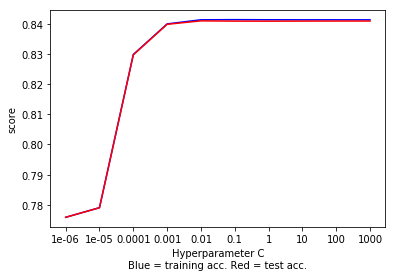

In [19]:
import matplotlib.pyplot as plt

train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

In [20]:
print(cv.best_params_)

{'C': 0.01}


In [21]:
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

Train accuracy: 0.8414111076512009
Test accuracy: 0.8432241128767637


In [22]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 80
Number of features after elimination 48


In [23]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [24]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.8415416913603809
Test accuracy: 0.8431537992781137
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     33101
           1       0.72      0.49      0.58      9565

    accuracy                           0.84     42666
   macro avg       0.79      0.72      0.74     42666
weighted avg       0.83      0.84      0.83     42666

{'C': 0.1}


In [25]:
from sklearn.metrics import roc_auc_score

y_pred_proba_lr = model.predict_proba(X_test)
y_pred_proba_lr_cv = cv.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)

roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
roc_index_lr_cv = roc_auc_score(y_test, y_pred_proba_lr_cv[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])

print("ROC index on test for `model`:", roc_index_lr)
print("ROC index on test for `cv`:", roc_index_lr_cv)
print("ROC index on test for `rfe_cv`:", roc_index_rfe_cv)

ROC index on test for `model`: 0.8686376216826156
ROC index on test for `cv`: 0.8682817591987823
ROC index on test for `rfe_cv`: 0.868573688351669


In [26]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr[:,1])
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test, y_pred_proba_lr_cv[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])

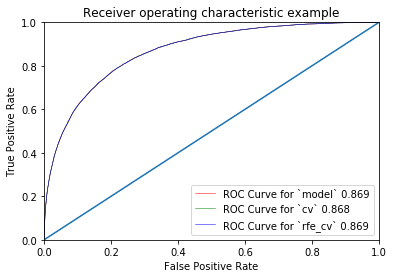

In [29]:
import matplotlib.pyplot as plt

plt.plot(fpr_lr, tpr_lr, label='ROC Curve for `model` {:.3f}'.format(roc_index_lr), color='red', lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='ROC Curve for `cv` {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='ROC Curve for `rfe_cv` {:.3f}'.format(roc_index_rfe_cv), color='blue', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.plot(range(40),range(40))
plt.show()

In [17]:
import pickle
lr_best = rfe_cv
roc_index_lr_best = roc_index_rfe_cv
tpr_lr_best = tpr_rfe_cv
fpr_lr_best = fpr_rfe_cv
with open('LR.pickle', 'wb') as f:
    pickle.dump([lr_best,roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)